# Работа с текстовыми данными (часть 3 – прототип чат бота) 

1. Изучите предложенный пример. 
2. Модифицируйте предложенный пример под свои пары вопрос-ответ и сформулируйте не менее 5 своих вопросов. 
3. Исследуйте работу системы и сделайте выводы о применимости к своему набору данных способов оценки схожести и структурирования информации и текстовых данных.

### Что такое чат-бот?

Чат-бот (англ. chatbot) — это программа, которая имитирует реальный разговор с пользователем. Вы все наверняка посещали веб-сайт, на котором написано «Привет! чем я могу вам помочь», и мы нажимаем на него и начинаем с ним общаться.

Глобально, чат-боты делятся на следующие типы:

- **Декларативные**, или необучаемые боты действуют в соответствии с заложенным в них сценарием.

- **Предиктивные**, или обучаемые чат-боты создаются при помощи комбинации искусственного интеллекта, машинного обучения и технологии обработки естественного языка.

В данной лабораторной работе мы займёмся разработкой первого варианта чат-бота, но с использованием языковой модели.

Мы создадим список возможных вопросов по теме(в нашем случае вопросы абитуриента ВШЭ), а также список возможных ответов на эти вопросы (по парам).

Далее мы смоделируем ситуацию, когда пользователь задаёт какой-то вопрос, мы находим вопрос из нашей "базы", максимально похожий на вопрос пользователя и предлагаем соответвтующий ответ из пары.

In [1]:
import spacy
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [2]:
questions = ["Я хочу поступить в ваш университет, как это можно сделать?",
            "На каких условиях я могу обучаться в НИУ ВШЭ?",
            "У меня есть результаты международного экзамена по математике и английскому. Могу ли я использовать их в качестве вступительных экзаменов?",
            "Предоставляет ли НИУ ВШЭ общежитие?",
            "Когда мне нужно подавать документы?",
            "Могу ли я обучаться в НИУ ВШЭ на английском языке?",
            "Могу ли я учиться полностью дистанционно и получить диплом Вышки? Есть ли онлайн-программы?",
            "Платится ли стипендия иностранным студентам?",
            "Нужен ли мне полис ДМС при поступлении в НИУ ВШЭ?",
            "Нужно ли мне проходить процедуру признания?",
            "Я учился в магистратуре за рубежом, могу ли я подать документы в магистратуру НИУ ВШЭ?",
            "Могу ли я перевестись с коммерческого места на бюджетное?"
            ]

answers = ["Поступить в НИУ ВШЭ можно разными способами, которые дополняют и не противоречат друг другу: принять участие в Олимпиаде для студентов и выпускников. Победители и призеры имеют возможность поступить на бюджетное место (стипендия Правительства РФ); принять участие в Международной олимпиаде Open Doors. Победители и призеры имеют возможность поступить на бюджетное место (стипендия Правительства РФ); принять участие в конкурсе портфолио в рамках отдельного конкурса для иностранных граждан; принять участие в конкурсе портфолио и сдать самостоятельно проводимые вступительные испытания очно в рамках общей приемной кампании наряду с российскими гражданами и поступить как на коммерческое, так и на бюджетное место.",
  "Обучение иностранных граждан осуществляется: на бюджетных местах (стипендия Правительства РФ); на бюджетных местах (наряду с российскими гражданами, для иностранных граждан, которые могут быть отнесены к соотечественникам); на коммерческих местах.",
  "Конечно. В случае, если вы являетесь обладателем сертификата международного экзамена по английскому языку, математике, биологии и (или) русскому языку, а также БЦТ по английскому языку или математике, то результаты данных экзаменов могут быть перезачтены в качестве вступительного испытания. Подробнее о перезачете результатов международных экзаменов.",
  "Места в общежитии предоставляются на все время обучения студентам, получившим полный грант на обучение. Стоимость проживания и адреса общежитий размещены на странице. Консультации по условиям размещения в общежитии НИУ ВШЭ можно получить у Дирекции по управлению общежитиями. Остальные варианты размещения – для получивших частичный грант и коммерческих студентов – опубликованы на странице My HSE House.  С 1 июня 2022 года открыта подача заявок на бронирование различных вариантов проживания. Необходимо зайти в специальный раздел личного кабинета, по ссылке перейти на регистрационную форму, заполнить ее и в дальнейшем с менеджером согласовать наиболее комфортный вариант. Кроме того, можно официально подать заявку через форму сервиса размещения студентов (вне общежитий). Обращаем внимание, что для подачи заявки нужно быть зарегистрированным в качестве иностранного абитуриента НИУ ВШЭ и оплатить 1-й семестр обучения. На сайте Управления размещения студентов можно посмотреть разные варианты размещения.",
  "Сроки проведения отбора на обучение, информация о возможности подачи документов для поступления на обучение в электронной форме и другая информация указана на странице «Как поступить в магистратуру».",
  "В НИУ ВШЭ реализуется более 30 англоязычных магистерских программ. Подробная информация размещена и обновляется в соответствующей секции на сайте International Admissions.",
  "Все онлайн-программы представляют собой очную форму обучения. После окончания обучения на онлайн-программе выдается такой же диплом НИУ ВШЭ, как и при обучении очно. Полный список программ здесь. Бюджетные места на онлайн-программах не предусмотрены, информация о возможных скидках указана на страницах самих программ. Так как обучение реализуется полностью в онлайн-формате, учебная виза не предусмотрена.",
  "Стипендия платится студентам согласно месту в рейтинге. Подробнее о видах, порядке начисления стипендии можно прочитать здесь.",
  "Полис Добровольного медицинского страхования приобретается иностранным гражданином самостоятельно до прибытия в Россию. Полис ДМС включает в себя медицинский осмотр, который студент обязан пройти по прибытию в РФ. По результатам медосмотра выдается справка о состоянии здоровья, которая предоставляется менеджеру программы и при заселении. Список компаний, с которыми сотрудничает НИУ ВШЭ размещен здесь. Вы можете выбрать компанию из списка, или заключить договор ДМС в любой другой компании.",
  "НИУ ВШЭ обладает правом самостоятельного признания иностранных документов об образовании. Признание документа об образовании проводится в личном кабинете иностранного абитуриента. Подробная информация здесь.",
  "Если Вы учились в магистратуре российского университета на бюджете, то поступить можно только на коммерческое место. Если Вы заканчивали магистратуру в иностранном университете, то поступление возможно как на бюджетное место, так и на коммерческое.",
  "Да! Перевод возможен при соблюдении следующих условий: - Наличие бюджетного (квотного) места на соответствующем курсе обучения; - Перевод осуществляется в рамках одной образовательной программы; - Перевод осуществляется в том же семестре, в котором был отчислен квотный студент. Для осуществления перевода Вам необходимо собрать следующие документы: - письменное заявление на имя ректора о переводе с коммерческого на бюджетное (квотное) место, подписанное деканом/руководителем  факультета/подразделения; - копия паспорта и перевод паспорта студента, желающего перевестись на бюджетное (квотное) место; - служебная записка от академического руководителя программы на имя проректора Ивана Валериевича Простакова о согласии на перевод с коммерческого на бюджетное (квотное) место; - копия приказа об отчислении студента-квотника, на место которого осуществляется перевод; - копия направления на обучение Минобрнауки РФ отчисленного студента-квотника. Все документы должны быть направлены в Дирекцию по привлечению иностранных студентов Валерии Сергеевне Купиной: vkupina@hse.ru."
  ]


In [3]:
# вопрос, который задаём
question = "У меня есть сертификат по английскому это меня будет плюсом?"
questions.append("У меня есть сертификат по английскому это меня будет плюсом?")


Используем spacy для лемматизации на русском языке, не забудем убрать знаки препинания, которые не несут для нас полезной информации в данном случае.

In [4]:
nlp = spacy.load('ru_core_news_lg')

In [5]:
n = len(questions)
parsed = [None] * n
tx2 = [None] * n

for i in range(n):
    parsed[i] = nlp(questions[i])
    tx2[i] = " ".join([token.lemma_ for token in parsed[i] if token.pos_ != 'PUNCT'])

In [6]:
tx2 #посмотрим на получившийся текст

['я хотеть поступить в ваш университет как это можно сделать',
 'на какой условие я мочь обучаться в ниу вшэ',
 'у меня быть результат международный экзамен по математика и английский мочь ли я использовать их в качество вступительный экзамен',
 'предоставлять ли ниу вшэ общежитие',
 'когда мне нужный подавать документ',
 'мочь ли я обучаться в ниу вшэ на английский язык',
 'мочь ли я учиться полностью дистанционно и получить диплом вышка быть ли онлайн - программы',
 'платится ли стипендия иностранный студент',
 'нужный ли мне полис дмс при поступление в ниу вшэ',
 'нужный ли мне проходить процедура признание',
 'я учиться в магистратура за рубеж мочь ли я подать документ в магистратура ниу вшэ',
 'мочь ли я перевестись с коммерческий место на бюджетный',
 'у меня быть сертификат по английский это меня быть плюс']

Теперь переведём наши тексты в вектора.

**CountVectorizer** - это функция, которая преобразует текстовые данные в матрицу Bag of Words. Он строит словарь всех уникальных слов в тексте и преобразует каждое предложение в вектор, где каждый элемент вектора представляет счетчик вхождений соответствующего слова в предложение.

**TfidfTransformer** - это класс, который преобразует матрицу Bag of Words в матрицу TF-IDF (Term Frequency-Inverse Document Frequency). TF-IDF - это статистическая мера, которая оценивает важность слова в документе, учитывая его частоту встречаемости в документе и обратную частоту встречаемости во всей коллекции документов. Преобразование TF-IDF позволяет учитывать важность слова не только в пределах одного предложения, но и в контексте всего текста.

In [7]:
vectorizer = CountVectorizer()
tk = vectorizer.fit_transform(tx2)

tk_tfidf = TfidfTransformer().fit_transform(tk)

В библиотеке spaCy есть функция подсчёта расстояния между векторами. В данном случае имеется в виду косинусное расстояние (формулу см. в материалах к семинару 13). 

Построим расстояния между вопросом пользователя и уже заготовленными вопросами.

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

# Считаем косинусные расстояния между текстами
tstat = cosine_similarity(tk, tk)
tstat_tfidf = cosine_similarity(tk_tfidf, tk_tfidf)

А теперь вывевем ответ на вопрос, который максимально похож на тот, что введён пользователем.

In [9]:
print(question)
max_index = np.argmax(tstat[n-1, 0:(n-2)])
print(answers[max_index])

У меня есть сертификат по английскому это меня будет плюсом?
Конечно. В случае, если вы являетесь обладателем сертификата международного экзамена по английскому языку, математике, биологии и (или) русскому языку, а также БЦТ по английскому языку или математике, то результаты данных экзаменов могут быть перезачтены в качестве вступительного испытания. Подробнее о перезачете результатов международных экзаменов.


In [10]:
print(question)
max_index = np.argmax(tstat_tfidf[n-1, 0:(n-2)])
print(answers[max_index])

У меня есть сертификат по английскому это меня будет плюсом?
Конечно. В случае, если вы являетесь обладателем сертификата международного экзамена по английскому языку, математике, биологии и (или) русскому языку, а также БЦТ по английскому языку или математике, то результаты данных экзаменов могут быть перезачтены в качестве вступительного испытания. Подробнее о перезачете результатов международных экзаменов.


Теперь попробуем использовать другую меру "похожести", а именно - корреляцию.

In [11]:
tkk = tk.toarray()
tstat_corr = np.corrcoef(tkk)

tkk_tfidf = tk_tfidf.toarray()
tstat_tfidf_corr = np.corrcoef(tkk_tfidf)

И выведем результаты - ответ на вопрос:

In [12]:
print(question)
max_index = np.argmax(tstat_corr[n-1, 0:(n-2)])
print(answers[max_index])

У меня есть сертификат по английскому это меня будет плюсом?
Конечно. В случае, если вы являетесь обладателем сертификата международного экзамена по английскому языку, математике, биологии и (или) русскому языку, а также БЦТ по английскому языку или математике, то результаты данных экзаменов могут быть перезачтены в качестве вступительного испытания. Подробнее о перезачете результатов международных экзаменов.


In [13]:
print(question)
max_index = np.argmax(tstat_tfidf_corr[n-1, 0:(n-2)])
print(answers[max_index])

У меня есть сертификат по английскому это меня будет плюсом?
Конечно. В случае, если вы являетесь обладателем сертификата международного экзамена по английскому языку, математике, биологии и (или) русскому языку, а также БЦТ по английскому языку или математике, то результаты данных экзаменов могут быть перезачтены в качестве вступительного испытания. Подробнее о перезачете результатов международных экзаменов.


Введём ещё одну меру похожести:

Коэффициент сходства Жаккара (Jaccard similarity coefficient) - это метрика, используемая для измерения схожести между двумя множествами. Коэффициент Жаккара определяется как отношение размера пересечения двух множеств к их объединению.

Формула для вычисления коэффициента сходства Жаккара:

$$J(A, B) = |A ∩ B| / |A ∪ B|$$

где:

$J(A, B)$ - коэффициент сходства Жаккара между множествами A и B.

$|A ∩ B|$ - количество элементов, присутствующих в обоих множествах (размер пересечения).

$|A ∪ B|$ - количество уникальных элементов в обоих множествах (размер объединения).

Коэффициент сходства Жаккара находится в диапазоне от 0 до 1, где 0 означает полное отсутствие сходства (нет общих элементов), а 1 - полное совпадение (множества идентичны).

In [14]:
jaccard_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        q_tokens_1 = set(tx2[i].split())
        q_tokens_2 = set(tx2[j].split())
        jaccard_similarity=  len(q_tokens_1.intersection(q_tokens_2))/len(q_tokens_1.union(q_tokens_2))
        jaccard_matrix[i, j] = jaccard_similarity

In [15]:
print(question)
max_index = np.argmax(jaccard_matrix[n-1, 0:(n-2)])
print(answers[max_index])

У меня есть сертификат по английскому это меня будет плюсом?
Конечно. В случае, если вы являетесь обладателем сертификата международного экзамена по английскому языку, математике, биологии и (или) русскому языку, а также БЦТ по английскому языку или математике, то результаты данных экзаменов могут быть перезачтены в качестве вступительного испытания. Подробнее о перезачете результатов международных экзаменов.


Для сравнения, попробуем посчитать ещё одну меру:

**Коэффициент сходства Рэнда** (simple matching coefficient = простой коэффициент соответствия) - это мера сходства между двумя наборами данных или классификациями. Это в целом широко распространённый "коэффициент похожести". Он используется для оценки степени согласованности между двумя различными способами разделения данных на группы или кластеры.

$$ SMC = \frac{Количество.совпадающих.элементов}{Общее.количество.элементов}$$

In [16]:
from sklearn.metrics import rand_score

rand_matrix = np.zeros((n, n))
rand_tfidf_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        rand = rand_score(tkk[i], tkk[j])
        rand_matrix[i, j] = rand

In [17]:
print(question)
max_index = np.argsort(rand_matrix[n-1, 0:(n-2)])[-1]
print(1, answers[max_index])

#посмотрим ещё 2 и 3 максимумы

max_2_index = np.argsort(rand_matrix[n-1, 0:(n-2)])[-2]
print(2, answers[max_2_index])

max_3_index = np.argsort(rand_matrix[n-1, 0:(n-2)])[-3]
print(3, answers[max_3_index])

У меня есть сертификат по английскому это меня будет плюсом?
1 Стипендия платится студентам согласно месту в рейтинге. Подробнее о видах, порядке начисления стипендии можно прочитать здесь.
2 Сроки проведения отбора на обучение, информация о возможности подачи документов для поступления на обучение в электронной форме и другая информация указана на странице «Как поступить в магистратуру».
3 Места в общежитии предоставляются на все время обучения студентам, получившим полный грант на обучение. Стоимость проживания и адреса общежитий размещены на странице. Консультации по условиям размещения в общежитии НИУ ВШЭ можно получить у Дирекции по управлению общежитиями. Остальные варианты размещения – для получивших частичный грант и коммерческих студентов – опубликованы на странице My HSE House.  С 1 июня 2022 года открыта подача заявок на бронирование различных вариантов проживания. Необходимо зайти в специальный раздел личного кабинета, по ссылке перейти на регистрационную форму, заполнить е

In [18]:
import warnings

warnings.filterwarnings('ignore')
        
for i in range(n):
    for j in range(n):
        rand = rand_score(tkk_tfidf[i], tkk_tfidf[j])
        rand_tfidf_matrix[i, j] = rand

warnings.filterwarnings('default')

In [19]:
print(question)
max_index = np.argmax(rand_tfidf_matrix[n-1, 0:(n-2)])
print(1, answers[max_index])

#посмотрим ещё 2 и 3 максимумы

max_2_index = np.argsort(rand_tfidf_matrix[n-1, 0:(n-2)])[-2]
print(2, answers[max_2_index])

max_3_index = np.argsort(rand_tfidf_matrix[n-1, 0:(n-2)])[-3]
print(3, answers[max_3_index])

У меня есть сертификат по английскому это меня будет плюсом?
1 Конечно. В случае, если вы являетесь обладателем сертификата международного экзамена по английскому языку, математике, биологии и (или) русскому языку, а также БЦТ по английскому языку или математике, то результаты данных экзаменов могут быть перезачтены в качестве вступительного испытания. Подробнее о перезачете результатов международных экзаменов.
2 Стипендия платится студентам согласно месту в рейтинге. Подробнее о видах, порядке начисления стипендии можно прочитать здесь.
3 Сроки проведения отбора на обучение, информация о возможности подачи документов для поступления на обучение в электронной форме и другая информация указана на странице «Как поступить в магистратуру».


# БОНУС

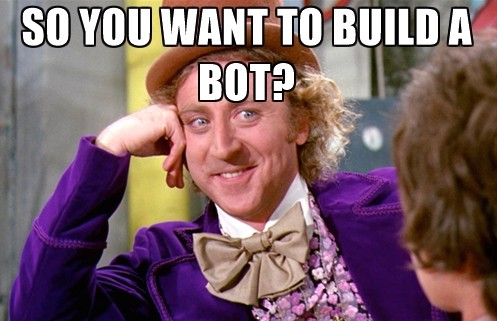

Эта часть не относится к основному заданию, это просто один из вариантов, как можно легко сделать собственного чат-бота, который тянет информацию с определённого сайта по API и способен отвечать на вопросы по теме. 

А именно, мы сделаем чат-бота, который может тянуть с сайта openweather.com информацию о погоде в формате json файла и отвечать на вопросы о погоде в данный момент в разных городах.

In [20]:
import spacy
import random 

nlp = spacy.load("en_core_web_md") 
# используем англоязычную модель, так как с сайта информация
# тянется на английском

# не забудьте скачать подходящую модель!

Для того, чтобы брать информацию с сайта openweather.com нам понадобится модуль requests.

Довольно часто для того, чтобы воспользоваться доступом по API, Вам нужно зарегистрироваться на сайте. В нашем случае, вам нужно зарегистрироваться [здесь](https://home.openweathermap.org/), а затем сгенерировать API ключ [здесь](https://home.openweathermap.org/api_keys).

**ВАЖНО**: новый api_key активируется НЕ СРАЗУ, это может занять до 2 часов.

In [21]:
import requests

api_key = "your_API_key"
def get_weather(city_name, api_key):
	api_url = "http://api.openweathermap.org/data/2.5/weather?q={}&appid={}".format(city_name, api_key)	
	response = requests.get(api_url)
	# нам возвращается целый словарь информации с сайта
	response_dict = response.json()
    # из словаря по ключу извлекаем информацию о погоде на данный момент
	weather = response_dict["weather"][0]["description"]
	if response.status_code == 200:
		return weather
	else:
		# если что-то пойдёт не так, мы получим это сообщение об ошибке
		print(f'[!]ERROR: HTTP {response.status_code} calling [{api_url}]')
		return None

Проверим, как работает эта функция:

In [25]:
weather = get_weather("Perm", api_key)
weather

'few clouds'

Теперь напишем функцию самого чат-бота.

Наш бот будет получать на вход вопрос о погоде в каком-либо городе и сообщать текущий статус.

Для обработки входящих вопросов мы снова воспользуемся "похожестью" между предложениями (косинусное расстояние). Для этого создадим небольшой список возможных вопросов к боту и если входящий вопрос "похож", а на самом деле, расстояние между хотя бы одним из этих предложений больше 0.75, то тогда мы продолжаем обрабатывать запрос. Иначе мы считаем, что пользователь спросил какую-то ерунду и возвращаем сообщение об ошибке и просим переформулировать запрос.

In [26]:
def chatbot(statement):
    weather = [nlp("Current weather in a city"),
               nlp('What is the weather in a city?'),
               nlp('Tell me the weather in a city')
              ]
    statement = nlp(statement)
    similarity_stat = [sent.similarity(statement) 
                       for sent in weather]
    min_similarity = 0.75
    if max(similarity_stat) >= min_similarity:
        
        for ent in statement.ents:
            if ent.label_ == "GPE": # GeoPolitical Entity
               city = ent.text
               break
            else:
               return "You need to tell me a correct name of a city to check."
        city_weather = get_weather(city, api_key)
        if city_weather is not None:
              return random.choice([f'In {city} the current weather is: {city_weather}',
                                    f'Today it is {city_weather} in {city}',
                                    f'It is {city_weather} in {city}.',
                                    f'It is {city_weather} in lovely {city}. Do you like to go there?'
                                   ])
        else:
              return "Something went wrong! Check your connection."
    else:
        return "Sorry, I don't understand that. Please rephrase your question!"


In [32]:
response = chatbot("What is the weather in Paris?")
print(response)

It is broken clouds in lovely Paris. Do you like to go there?


Далее можно продумывать более точные пользовательские сценарии(например, ситуация, когда в сообщении упоминаются два города), создать разнообразную базу ответов и всё более совершенствовать систему.

Если хотите попробовать сделать что-то своё, то вот один из простых вариантов:

http://api.open-notify.org/iss-now.json

По этой ссылке, даже без генерации API ключа, можно получать небольшой словарик с координатами положения Международной космической станции (по широте и долготе)

http://api.open-notify.org/astros.json

По этой ссылке - список имён космонавтов, которые прямо сейчас на находятся на МКС.

Можете попробовать сделать чат бота, который может отвечать на вопросы, заданные по этой теме. 

Либо попробовать самостоятельно найти API интересующего Вас сайта и сделать бота.  